In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


# **Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set()
%matplotlib inline

Setting the date column as index to facilitate time series analysis

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/Data science projects /MTNN Historical Data.csv',
                       parse_dates=['Date'], #specify which column is to be parsed as date while reading the csv file
                       date_format="%d/%m/%Y", #setting the date format
                       infer_datetime_format=True).set_index('Date').to_period('D')
data = raw_data.copy()
data

<ipython-input-3-50ba4533bfdf>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_data = pd.read_csv('/content/drive/MyDrive/Data science projects /MTNN Historical Data.csv',


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-04-04,229.0,232.0,229.0,229.0,1.84M,-1.29%
2024-04-03,232.0,232.0,232.0,225.0,1.31M,0.00%
2024-04-02,232.0,232.0,235.0,220.0,203.03K,0.00%
2024-03-28,232.0,229.9,232.0,229.9,3.21M,0.91%
2024-03-27,229.9,231.0,231.0,229.9,2.63M,-0.48%
...,...,...,...,...,...,...
2020-01-08,109.5,107.6,109.5,108.0,11.95M,1.77%
2020-01-07,107.6,108.0,107.6,107.6,3.41M,-0.37%
2020-01-06,108.0,109.0,108.5,108.0,3.02M,-0.92%


#**Data preprocessing**

In [4]:
data.shape

(1057, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1057 entries, 2024-04-04 to 2020-01-02
Freq: D
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1057 non-null   float64
 1   Open      1057 non-null   float64
 2   High      1057 non-null   float64
 3   Low       1057 non-null   float64
 4   Vol.      1057 non-null   object 
 5   Change %  1057 non-null   object 
dtypes: float64(4), object(2)
memory usage: 57.8+ KB


There are no missing values form the dataset as shown above

### converting Change % and Vol object in the dataset into floats

In [6]:
data.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [7]:
converted_data = data.copy()


#creating a function that converts the notations into digit.
def conv(col):
    if converted_data[col].dtype == object:
      arr = list(converted_data[col])
      for i in arr:
        if 'M' in i:
          idx = arr.index(i)
          arr[idx] = i.replace('M', '0000')
          arr[idx] = arr[idx].replace('.', '')
        elif 'K' in i:
          idx = arr.index(i)
          arr[idx] = i.replace('K', '0')
          arr[idx] = arr[idx].replace('.', '')
        else:
          pass
      else:
        pass
      return arr



In [8]:
converted = conv('Vol.')
converted

['1840000',
 '1310000',
 '203030',
 '3210000',
 '2630000',
 '5250000',
 '11060000',
 '1490000',
 '728420',
 '381590',
 '2840000',
 '1610000',
 '2040000',
 '3210000',
 '2900000',
 '1720000',
 '1680000',
 '5870000',
 '2020000',
 '1010000',
 '5000000',
 '4600000',
 '1680000',
 '1040000',
 '1230000',
 '1420000',
 '1130000',
 '1120000',
 '1160000',
 '1310000',
 '810320',
 '299740',
 '1190000',
 '1250000',
 '997550',
 '1200000',
 '1330000',
 '281970',
 '535840',
 '276880',
 '2430000',
 '1770000',
 '904440',
 '1800000',
 '10730000',
 '1780000',
 '792310',
 '884980',
 '1630000',
 '885780',
 '3040000',
 '6080000',
 '2510000',
 '1660000',
 '1670000',
 '1590000',
 '2830000',
 '382850',
 '3410000',
 '3500000',
 '2280000',
 '4020000',
 '804520',
 '1370000',
 '441140',
 '564330',
 '675810',
 '3100000',
 '680400',
 '2200000',
 '819100',
 '925740',
 '2360000',
 '2420000',
 '1520000',
 '839830',
 '763930',
 '1550000',
 '1070000',
 '326070',
 '480430',
 '3930000',
 '5580000',
 '439950',
 '404970',
 '544

In [9]:
converted_data['volume'] = converted
converted_data

,Price,Open,High,Low,Vol.,Change %,volume
Date,,,,,,,
2024-04-04,229.0,232.0,229.0,229.0,1.84M,-1.29%,1840000
2024-04-03,232.0,232.0,232.0,225.0,1.31M,0.00%,1310000
2024-04-02,232.0,232.0,235.0,220.0,203.03K,0.00%,203030
2024-03-28,232.0,229.9,232.0,229.9,3.21M,0.91%,3210000
2024-03-27,229.9,231.0,231.0,229.9,2.63M,-0.48%,2630000
...,...,...,...,...,...,...,...
2020-01-08,109.5,107.6,109.5,108.0,11.95M,1.77%,11950000
2020-01-07,107.6,108.0,107.6,107.6,3.41M,-0.37%,3410000
2020-01-06,108.0,109.0,108.5,108.0,3.02M,-0.92%,3020000


### parsing IDR to floats

In [10]:
converted_data.info

<bound method DataFrame.info of             Price   Open   High    Low     Vol. Change %    volume
Date                                                              
2024-04-04  229.0  232.0  229.0  229.0    1.84M   -1.29%   1840000
2024-04-03  232.0  232.0  232.0  225.0    1.31M    0.00%   1310000
2024-04-02  232.0  232.0  235.0  220.0  203.03K    0.00%    203030
2024-03-28  232.0  229.9  232.0  229.9    3.21M    0.91%   3210000
2024-03-27  229.9  231.0  231.0  229.9    2.63M   -0.48%   2630000
...           ...    ...    ...    ...      ...      ...       ...
2020-01-08  109.5  107.6  109.5  108.0   11.95M    1.77%  11950000
2020-01-07  107.6  108.0  107.6  107.6    3.41M   -0.37%   3410000
2020-01-06  108.0  109.0  108.5  108.0    3.02M   -0.92%   3020000
2020-01-03  109.0  109.0  109.0  109.0    4.09M    0.00%   4090000
2020-01-02  109.0  105.0  109.0  109.0  380.73K    3.81%    380730

[1057 rows x 7 columns]>

In [11]:
#creating a function that removes the % sign from the figures
def idr_parser(cur_str):
  try:
    cur_str = str(cur_str)
  except:
    pass
  cur_str = re.sub('[%]', '', cur_str)
  return cur_str

In [12]:
col_to_conv = converted_data.columns[-2:]
col_to_conv

Index(['Change %', 'volume'], dtype='object')

In [13]:


for col in col_to_conv:
  items = converted_data[col].to_list()
  converted_data[col] = [float(idr_parser(item)) for item in items]

In [14]:
converted_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1057 entries, 2024-04-04 to 2020-01-02
Freq: D
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1057 non-null   float64
 1   Open      1057 non-null   float64
 2   High      1057 non-null   float64
 3   Low       1057 non-null   float64
 4   Vol.      1057 non-null   object 
 5   Change %  1057 non-null   float64
 6   volume    1057 non-null   float64
dtypes: float64(6), object(1)
memory usage: 66.1+ KB


### Dropping the vol. column from the dataset as we have a copy in float format

In [15]:
data_converted_to_floats = converted_data.drop('Vol.', axis = 1)
data_converted_to_floats

,Price,Open,High,Low,Change %,volume
Date,,,,,,
2024-04-04,229.0,232.0,229.0,229.0,-1.29,1840000.0
2024-04-03,232.0,232.0,232.0,225.0,0.00,1310000.0
2024-04-02,232.0,232.0,235.0,220.0,0.00,203030.0
2024-03-28,232.0,229.9,232.0,229.9,0.91,3210000.0
2024-03-27,229.9,231.0,231.0,229.9,-0.48,2630000.0
...,...,...,...,...,...,...
2020-01-08,109.5,107.6,109.5,108.0,1.77,11950000.0
2020-01-07,107.6,108.0,107.6,107.6,-0.37,3410000.0
2020-01-06,108.0,109.0,108.5,108.0,-0.92,3020000.0


# **Data Visualization**

### Data distribution

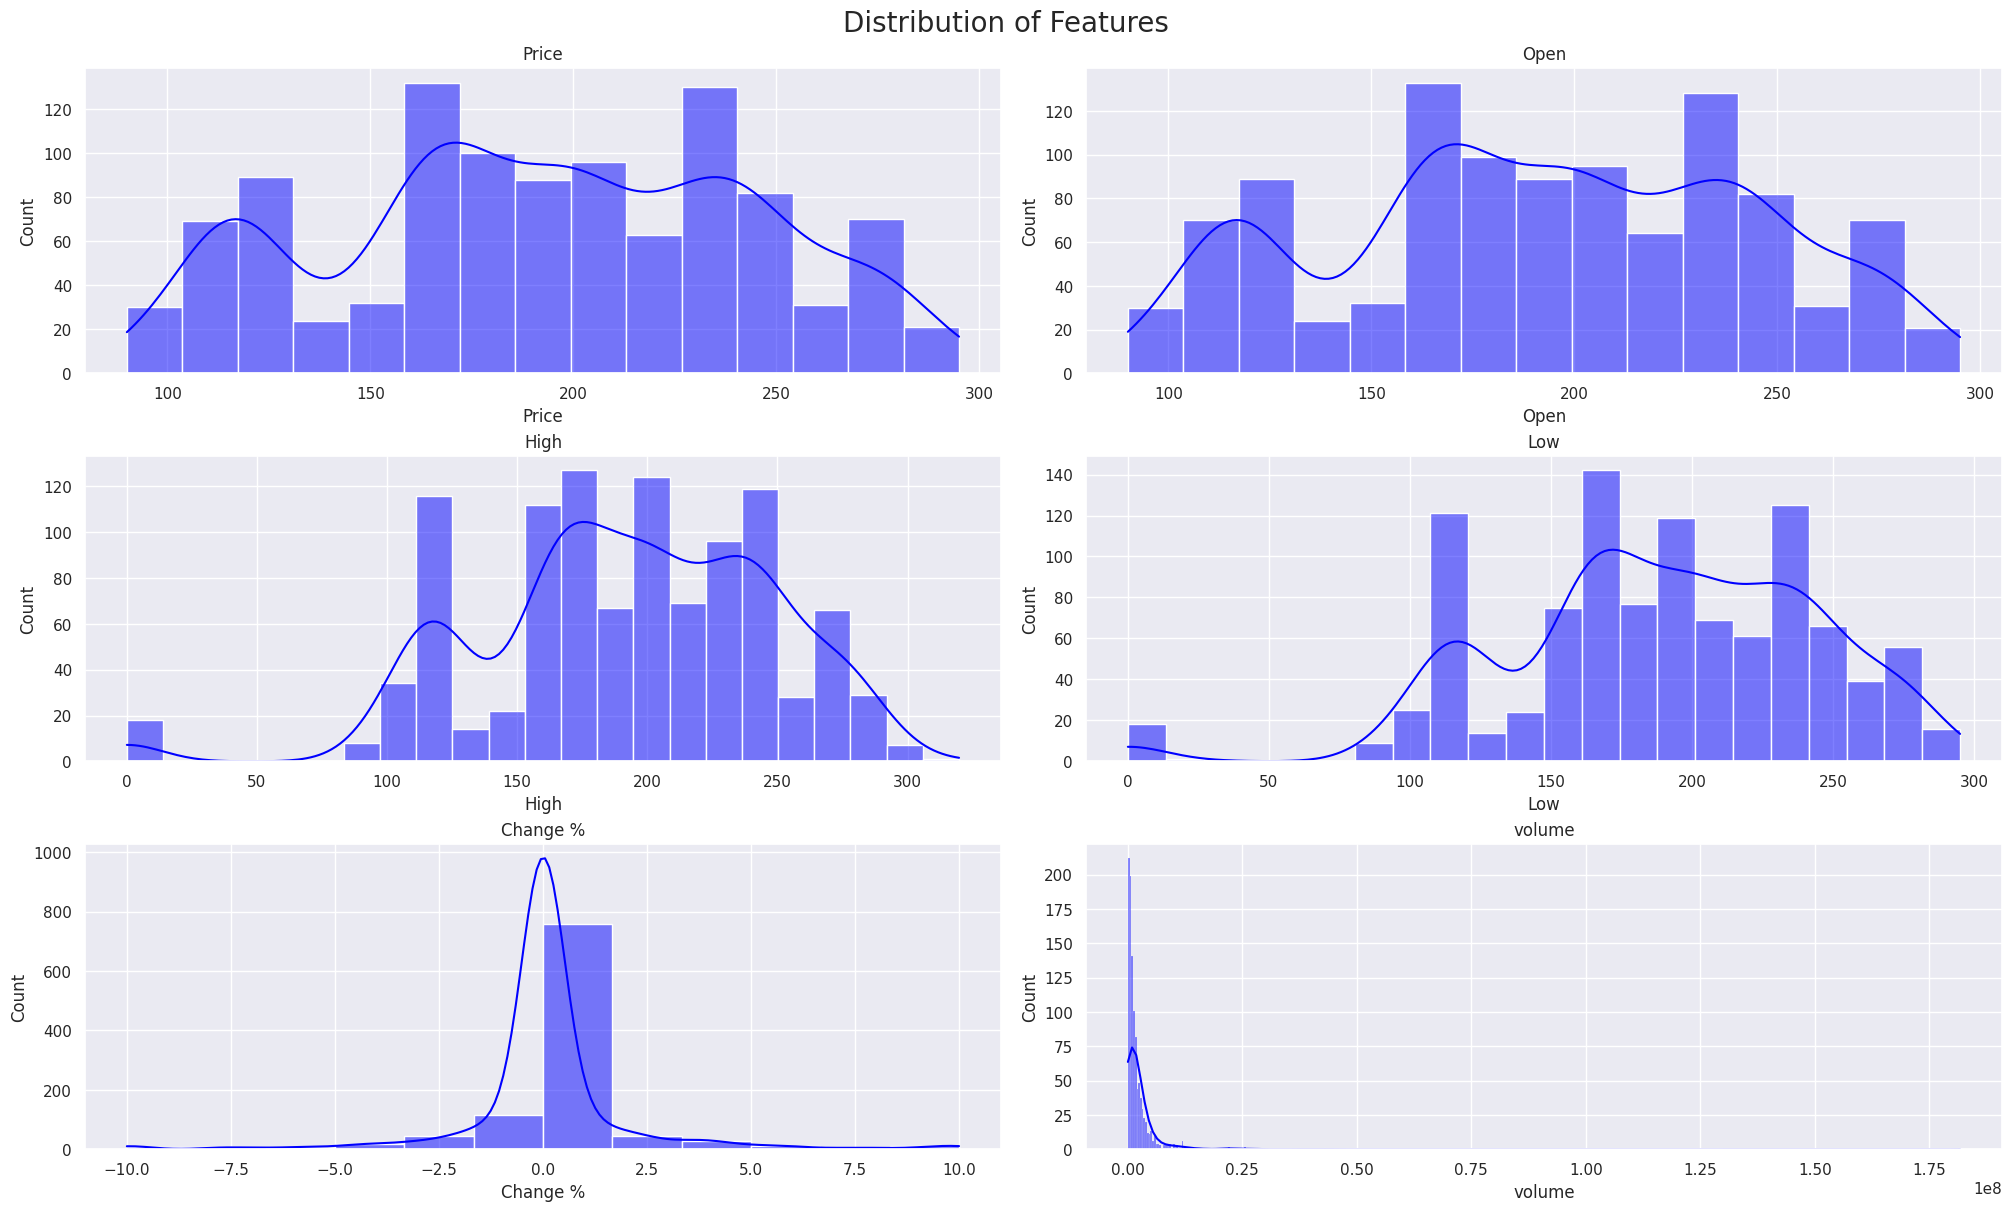

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12), constrained_layout=True)

for i in range(3):
    for j in range(2):
        if (i * 2 + j) < len(data_converted_to_floats.columns):
            col = data_converted_to_floats.columns[i * 2 + j]
            sns.histplot(data_converted_to_floats[col], kde=True, color='blue', ax=axes[i, j])
            axes[i, j].set_title(col)

fig.suptitle('Distribution of Features', fontsize=20)
plt.show()

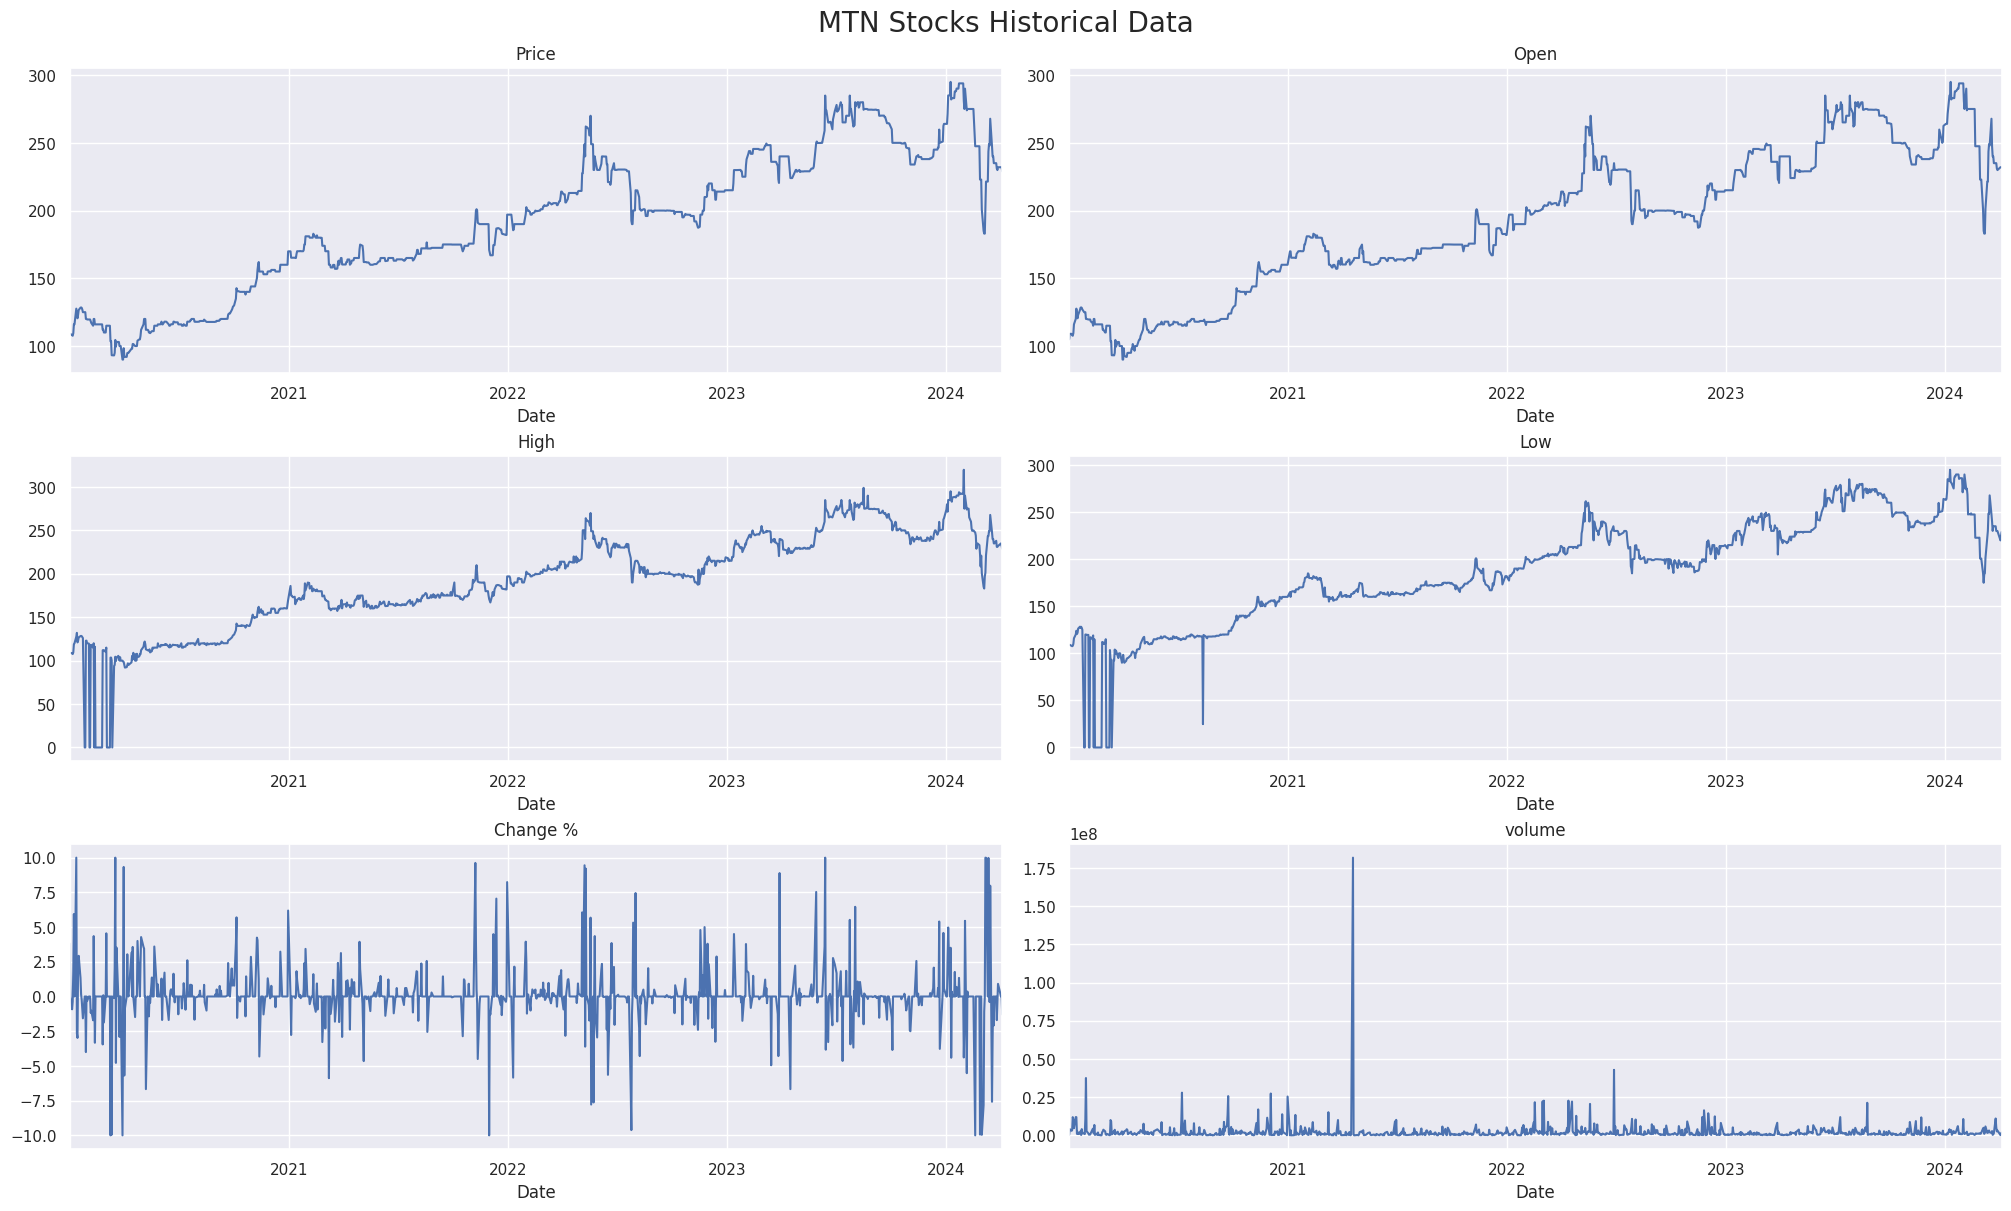

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12), constrained_layout=True)

for i in range(3):
    for j in range(2):
        if (i * 2 + j) < len(data_converted_to_floats.columns):
            col = data_converted_to_floats.columns[i * 2 + j]
            data_converted_to_floats[col].plot(ax=axes[i,j])
            axes[i, j].set_title(col)

fig.suptitle('MTN Stocks Historical Data', fontsize=20)
plt.show()

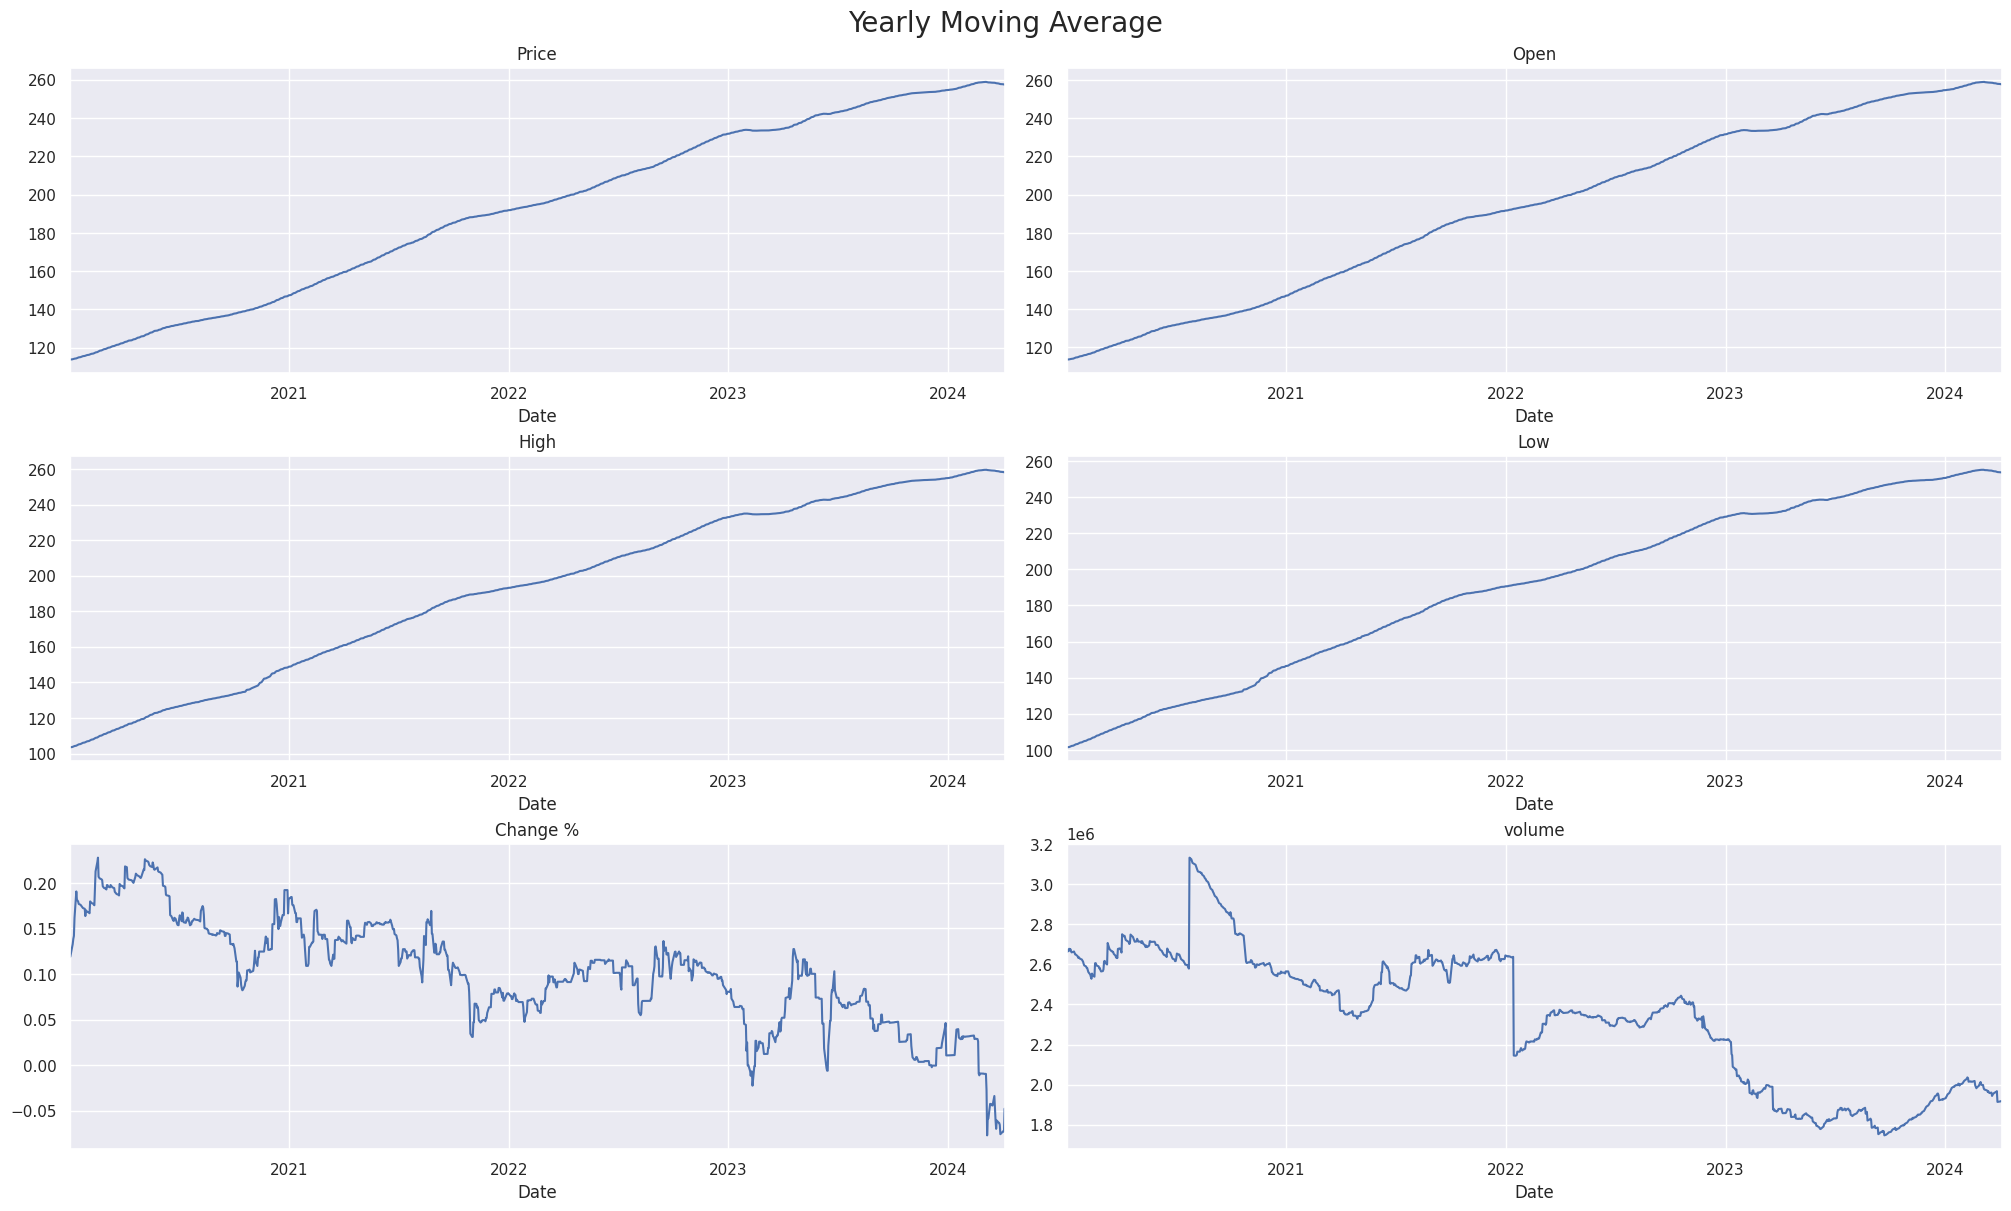

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12), constrained_layout=True)

for i in range(3):
    for j in range(2):
        if (i * 2 + j) < len(data_converted_to_floats.columns):
            col = data_converted_to_floats.columns[i * 2 + j]
            data_converted_to_floats[col].rolling(window=365,
                                                  center=True,
                                                  min_periods=183,
                                                  ).mean().plot(ax=axes[i,j])
            axes[i, j].set_title(col)

fig.suptitle('Yearly Moving Average', fontsize=20)
plt.show()

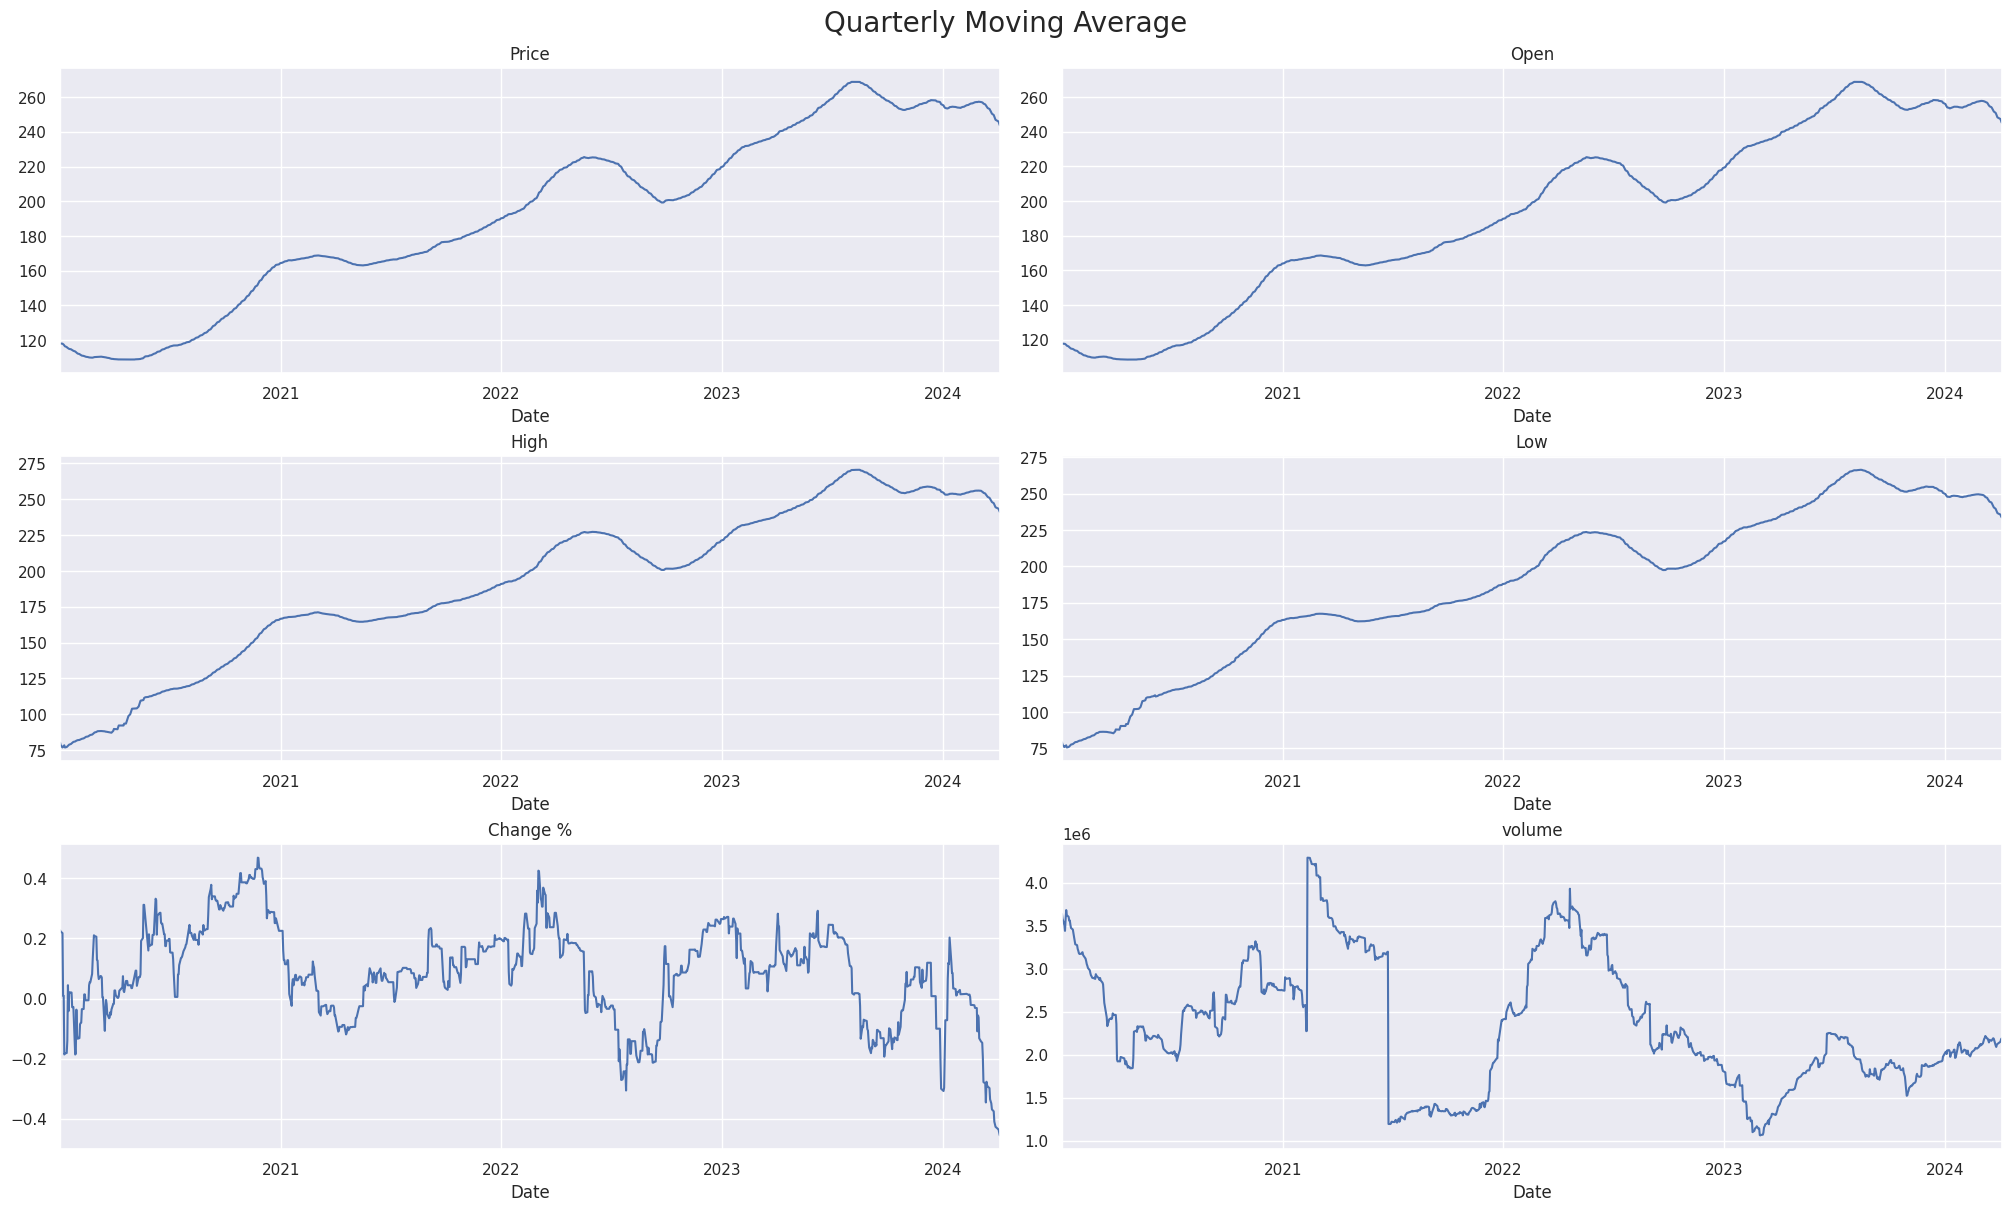

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12), constrained_layout=True)

for i in range(3):
    for j in range(2):
        if (i * 2 + j) < len(data_converted_to_floats.columns):
            col = data_converted_to_floats.columns[i * 2 + j]
            data_converted_to_floats[col].rolling(window=90,
                                                  center=True,
                                                  min_periods=45,
                                                  ).mean().plot(ax=axes[i,j])
            axes[i, j].set_title(col)

fig.suptitle('Quarterly Moving Average', fontsize=20)
plt.show()

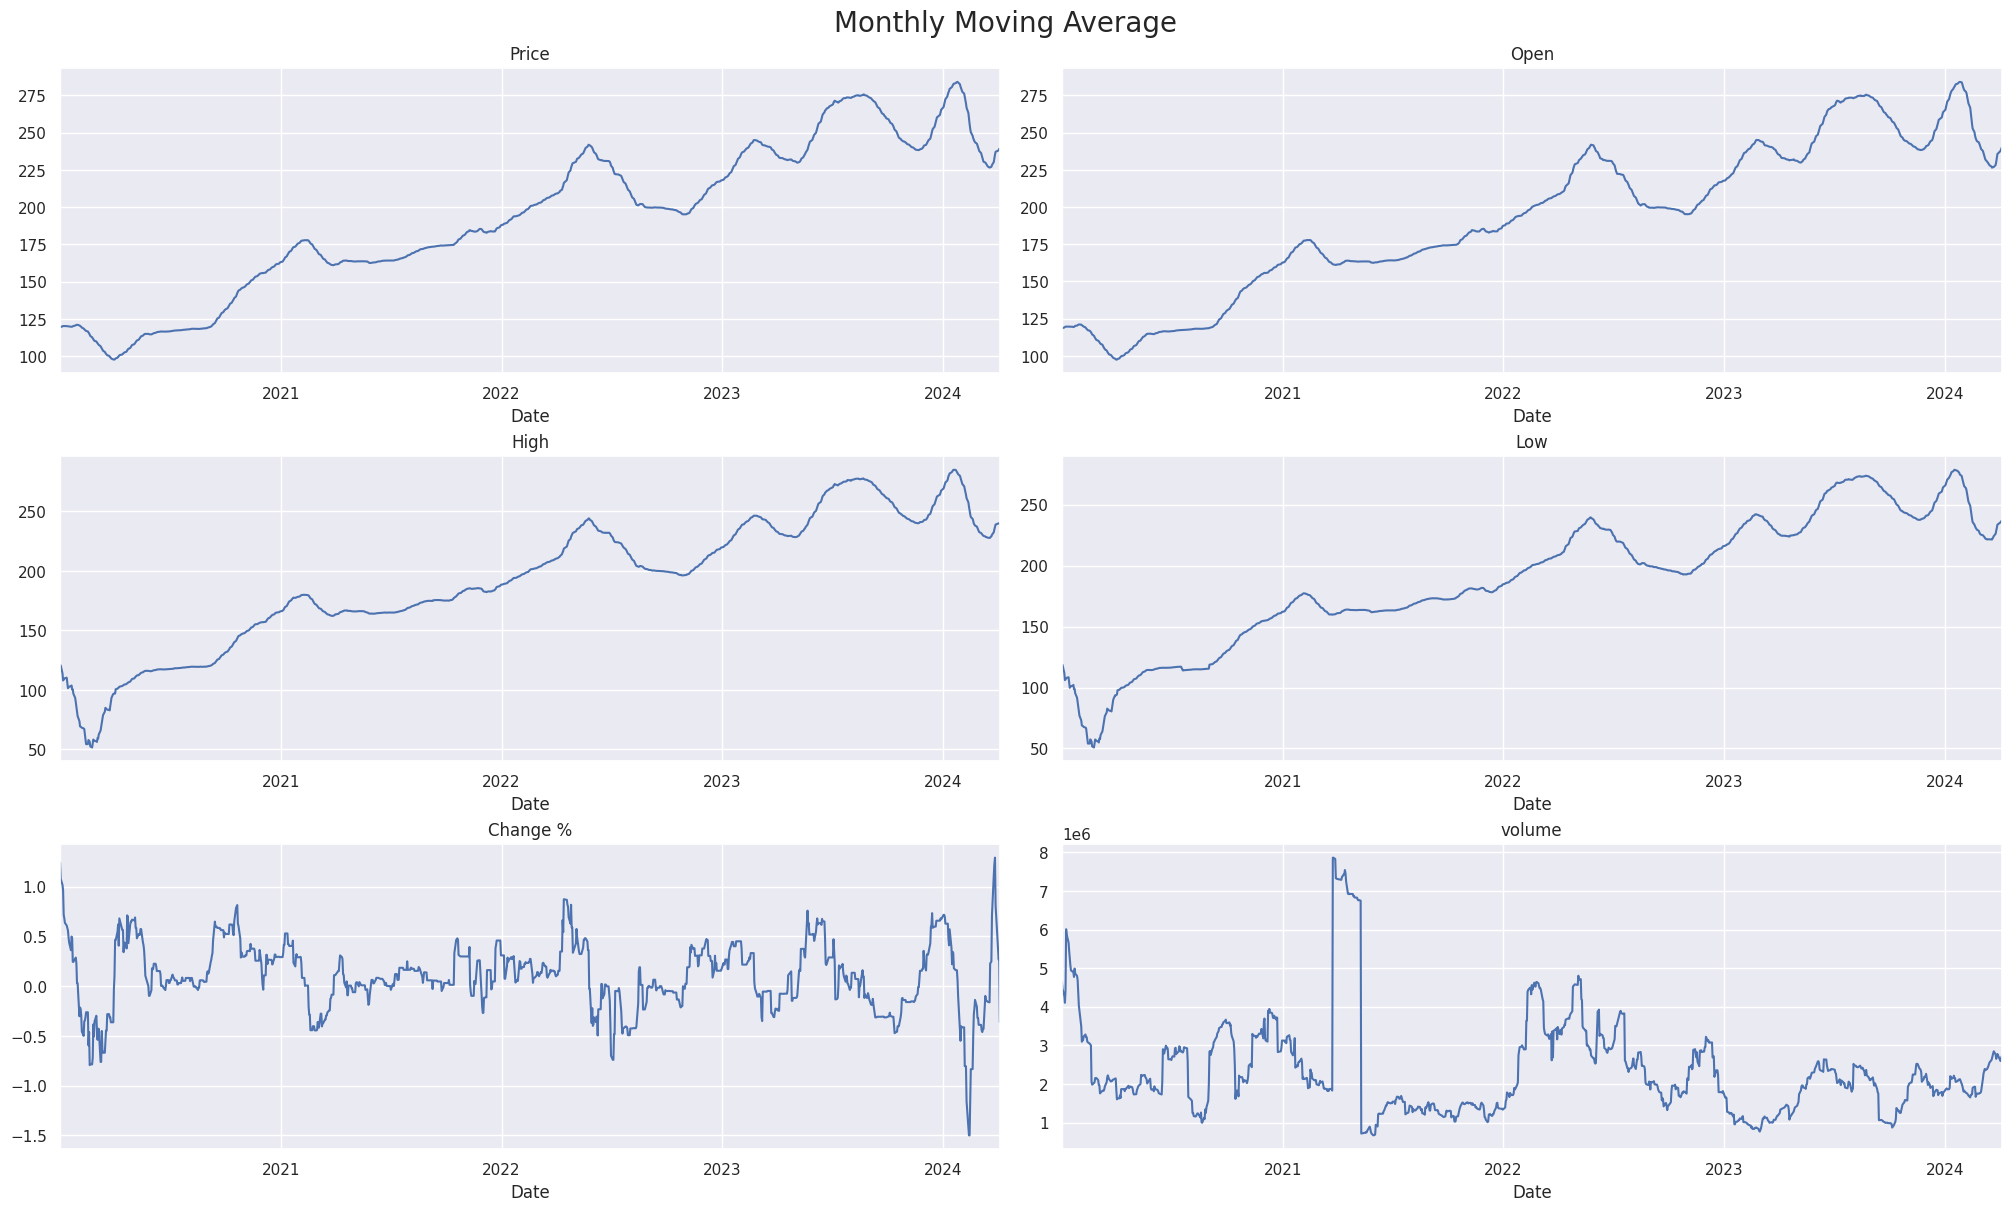

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(20, 12), constrained_layout=True)

for i in range(3):
    for j in range(2):
        if (i * 2 + j) < len(data_converted_to_floats.columns):
            col = data_converted_to_floats.columns[i * 2 + j]
            data_converted_to_floats[col].rolling(window=30,
                                                  center=True,
                                                  min_periods=15,
                                                  ).mean().plot(ax=axes[i,j])
            axes[i, j].set_title(col)

fig.suptitle('Monthly Moving Average', fontsize=20)
plt.show()

## **Time Series Decompostion**

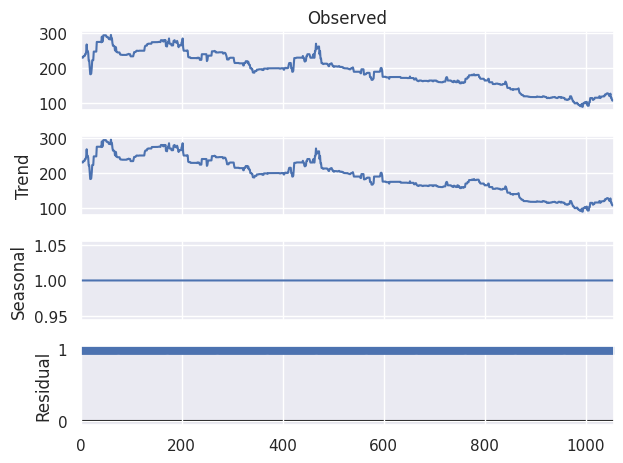

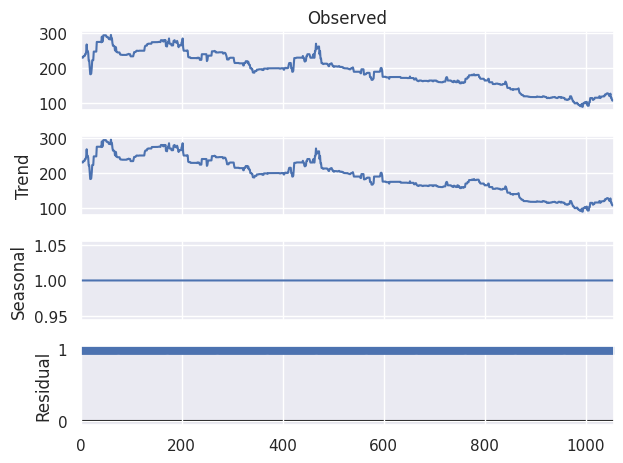

In [21]:
seasonal_decompose(data_converted_to_floats['Price'].values, model='multiplicative', period=1).plot()

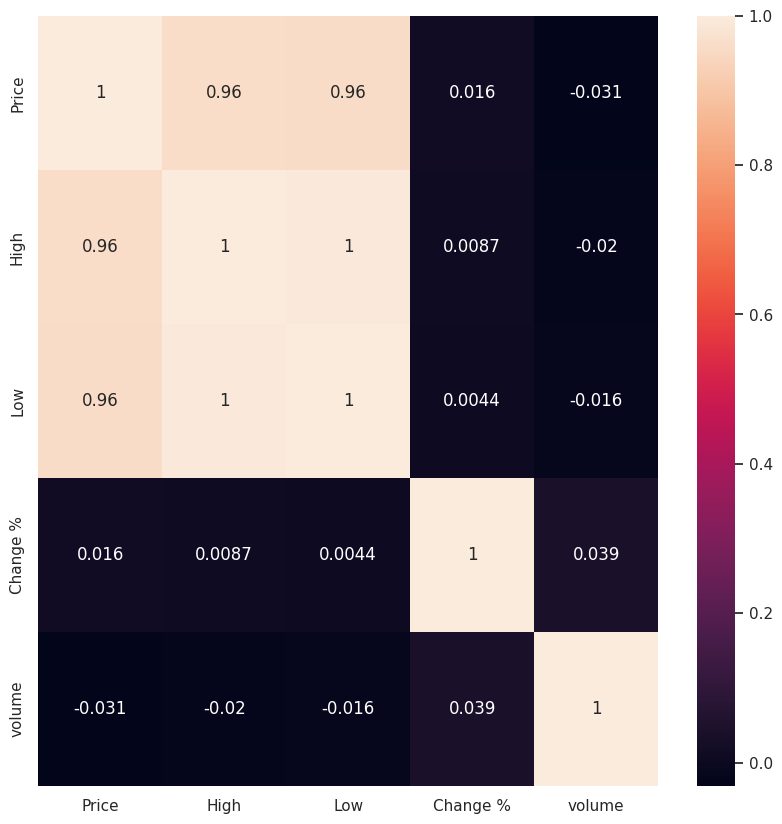

In [22]:
plt.figure(figsize=(10,10))
col_to_keep = data_converted_to_floats[data_converted_to_floats.columns[:]]
corr = col_to_keep.drop('Open', axis=1).corr()
sns.heatmap(corr, cmap='rocket', annot=True)
plt.show()



## **Training the data model**

In [23]:
num_features = 1 # univariate
target = data_converted_to_floats.filter(['Price'])
target.values

array([[229.],
       [232.],
       [232.],
       ...,
       [108.],
       [109.],
       [109.]])

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_target = scaler.fit_transform(target)
scaled_target

array([[0.67804878],
       [0.69268293],
       [0.69268293],
       ...,
       [0.08780488],
       [0.09268293],
       [0.09268293]])

In [25]:
scaled_target.shape

(1057, 1)

In [26]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(scaled_target, test_size=0.2, random_state=365)
train_data.shape, test_data.shape

((845, 1), (212, 1))

In [27]:

def datagen(data, step):
    inputs = []
    target = []

    for i in range(len(data)-step-1):
        inputs.append(data[i:i+step, 0])
        target.append(data[i+step, 0])

    return np.array(inputs), np.array(target)

In [28]:
step = 50
x_train, y_train = datagen(train_data, step)
x_test, y_test = datagen(test_data, step)

In [29]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], num_features)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], num_features)
x_train.shape

(794, 50, 1)

In [30]:
train_size = int(len(scaled_target) * .8)
train_size

845

In [31]:
real_test_data = target.values[train_data.shape[0]:len(target),:]
_, real_y_test = datagen(real_test_data, step)

#**MODEL**

## **STACKED LONG SHORT-TERM MEMORY**

In [32]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(step,1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy',tf.keras.metrics.MeanSquaredError(),
             tf.keras.metrics.RootMeanSquaredError()],

)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
### Training
# That's where we train the model we have built.

# set the batch size
batch_size = 1

# set a maximum number of training epochs
max_epochs = 10

# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
# note that this time the train, validation and test data are not iterable

model.fit(
    x_train, y_train,
    validation_data=(x_test,y_test),
    batch_size=batch_size,
    callbacks=[early_stopping], # early stopping
    epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
    verbose = 2 # making sure we get enough information about the training process
)

Epoch 1/10
794/794 - 42s - loss: 0.0669 - accuracy: 0.0025 - mean_squared_error: 0.0669 - root_mean_squared_error: 0.2586 - val_loss: 0.0747 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0747 - val_root_mean_squared_error: 0.2734 - 42s/epoch - 53ms/step
Epoch 2/10
794/794 - 38s - loss: 0.0629 - accuracy: 0.0025 - mean_squared_error: 0.0629 - root_mean_squared_error: 0.2509 - val_loss: 0.0744 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0744 - val_root_mean_squared_error: 0.2727 - 38s/epoch - 48ms/step
Epoch 3/10
794/794 - 35s - loss: 0.0629 - accuracy: 0.0000e+00 - mean_squared_error: 0.0629 - root_mean_squared_error: 0.2507 - val_loss: 0.0733 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0733 - val_root_mean_squared_error: 0.2707 - 35s/epoch - 45ms/step
Epoch 4/10
794/794 - 37s - loss: 0.0620 - accuracy: 0.0025 - mean_squared_error: 0.0620 - root_mean_squared_error: 0.2490 - val_loss: 0.0749 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0749 - val_

In [34]:
preds = model.predict(x_test)
preds = scaler.inverse_transform(preds)
rmse = math.sqrt(mean_squared_error(real_y_test, preds))
print("RMSE: ", rmse)

6/6 [==============================] - 2s 48ms/step
RMSE:  86.67281594710795


In [35]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

6/6 [==============================] - 0s 63ms/step


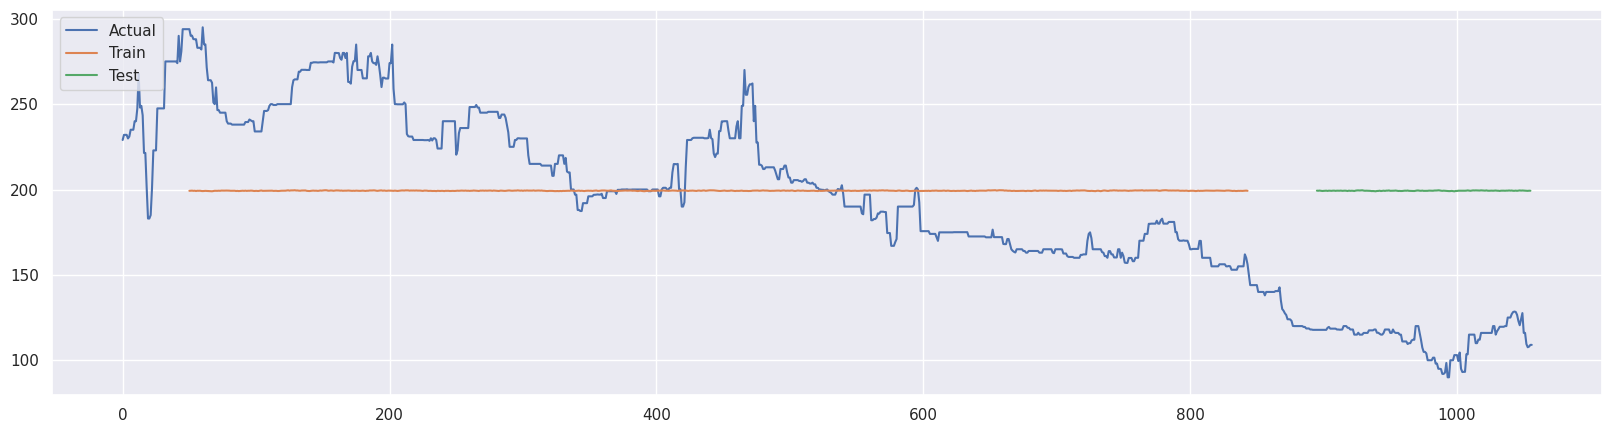

In [36]:
plt.figure(figsize=(20,5))

plt.plot(target.values)

trainPredictPlot = np.empty_like(scaled_target)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[step:len(train_predict)+step, :] = train_predict
plt.plot(trainPredictPlot)

testPredictPlot = np.empty_like(scaled_target)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(step*2)+1:len(scaled_target)-1, :] = test_predict
plt.plot(testPredictPlot)

plt.legend(['Actual','Train','Test'], loc='upper left')

plt.show()